In [0]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, re, json, random
import shutil
from shutil import copyfile

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%reload_ext autoreload
%autoreload 2
%matplotlib inline

path = '/content'

In [72]:
!ls /content

bad.list  darknet53.conv.74  predictions.jpg  test_cls	 train
cfg_fish  drive		     result.txt       test_stg1  train_yolo
darknet   fish_bbox	     sample_data      test_stg2  weights


## Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f train.zip

 98% 819M/832M [00:09<00:00, 85.8MB/s]
100% 832M/832M [00:09<00:00, 96.1MB/s]


In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f test_stg1.zip

 89% 206M/231M [00:02<00:00, 57.5MB/s]
100% 231M/231M [00:03<00:00, 79.8MB/s]


In [0]:
!unzip -q train.zip

In [0]:
!unzip -q test_stg1.zip

In [0]:
!rm train.zip test_stg1.zip

In [0]:
!rm train/.DS_Store

In [0]:
!rm -r __MACOSX

In [0]:
!cp -r /content/drive/My\ Drive/DL_projects/Data/fish_monitor/fish_bbox ./

In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f test_stg2.7z

100% 1.07G/1.07G [00:10<00:00, 86.8MB/s]
100% 1.07G/1.07G [00:10<00:00, 112MB/s] 


In [0]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [0]:
!p7zip -d test_stg2.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1152137421 bytes (1099 MiB)

Extracting archive: test_stg2.7z
--
Path = test_stg2.7z
Type = 7z
Physical Size = 1152137421
Headers Size = 82081
Method = LZMA:25
Solid = +
Blocks = 1

  0%      0% - test_stg2/image_00001.jpg                                  0% 38 - test_stg2/image_00039.jpg                                     0% 80 - test_stg2/image_00081.jpg                                     1% 125 - test_stg2/image_00126.jpg                                    

In [0]:
!mkdir test_cls

## Install cuDNN

In [73]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
!tar -xzvf /content/drive/My\ Drive/DL_projects/cv_fish/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
#!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a


## Install darknet

In [0]:
#!git clone https://github.com/pjreddie/darknet
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 10055, done.
remote: Total 10055 (delta 0), reused 0 (delta 0), pack-reused 10055
Receiving objects: 100% (10055/10055), 10.04 MiB | 19.29 MiB/s, done.
Resolving deltas: 100% (6726/6726), done.


Activate GPU and cuDNN

In [0]:
os.chdir('darknet')

with open('Makefile') as f:
    content = f.readlines()

updated = []
for line in content:
    if line.startswith('GPU='):
        line = f'GPU=1\n'
    if line.startswith('CUDNN='):
        line = f'CUDNN=1\n'
    updated.append(line)

with open('Makefile', 'w') as f:
    for line in updated:
        f.write(line)

In [0]:
!make

In [0]:
!ls /content/darknet

## Prepare data (labels, train/val split)

In [0]:
label_clss = ['DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']
no_bbs = ['img_00568.jpg', 'img_01958.jpg', 'img_07008.jpg', 'img_00425.jpg',
          'img_04798.jpg', 'img_06460.jpg', 'img_02292.jpg', 'img_00576.jpg',
          'img_00379.jpg', 'img_06773.jpg', 'img_05444.jpg', 'img_06082.jpg',
          'img_03183.jpg', 'img_04558.jpg', 'img_02785.jpg']

img_files = []
train_files = []
valid_files = []
np.random.seed(135)
for c in label_clss:
    fs = os.listdir(os.path.join(path, 'train', c))
    img_files += [c+'/'+f for f in fs if f not in no_bbs]
    
    mask = np.random.rand(len(fs)) > 0.1
    train_files += [f for f in list(np.array(fs)[mask]) if f not in no_bbs]
    valid_files += [f for f in list(np.array(fs)[~mask]) if f not in no_bbs]
np.random.shuffle(train_files)

gt = {}
for c in label_clss:
    with open(os.path.join(path, 'fish_bbox', c.lower()+'_labels.json')) as f:
        gt[c] = json.load(f)

In [0]:
# save required files in train_yolo
if not os.path.exists(os.path.join(path, 'train_yolo')):
    os.mkdir(os.path.join(path, 'train_yolo'))

for i in range(len(img_files)):
    # load image size
    im = Image.open(os.path.join(path, 'train', img_files[i]))
    width, height = im.size
    width, height = float(width), float(height)
    
    # correct bbox to yolo format and save to 'train_yolo'
    cls, fname = img_files[i].split('/')
    mask = list(map(lambda x: x['filename'].split('/')[-1]==fname, gt[cls]))
    bbs = np.array(gt[cls])[mask][0]['annotations']
    bboxes = [[(b['x']+0.5*b['width'])/width, (b['y']+0.5*b['height'])/height, b['width']/width, b['height']/height] for b in bbs]
    with open(os.path.join(path, 'train_yolo', fname.split('.')[0]+'.txt'), 'w') as f:
        for box in bboxes:
            f.write(f'0 {box[0]} {box[1]} {box[2]} {box[3]}\n')
            
    # copy images to 'train_yolo'
    copyfile(os.path.join(path, 'train', img_files[i]), os.path.join(path, 'train_yolo', fname))

In [0]:
# save required files to cfg_fish
if not os.path.exists(os.path.join(path, 'cfg_fish')):
    os.mkdir(os.path.join(path, 'cfg_fish'))

with open(os.path.join(path, 'cfg_fish', 'train.txt'), 'w') as f:
    for fname in train_files:
        f.write('train_yolo/'+fname+'\n')

with open(os.path.join(path, 'cfg_fish', 'valid.txt'), 'w') as f:
    for fname in valid_files:
        f.write('train_yolo/'+fname+'\n')

with open(os.path.join(path, 'cfg_fish', 'obj.data'), 'w') as f:
    f.write("classes= 1\n")
    f.write("train  = cfg_fish/train.txt\n")
    f.write("valid  = cfg_fish/valid.txt\n")
    f.write("names = cfg_fish/obj.names\n")
    f.write("backup = weights/")

with open(os.path.join(path, 'cfg_fish', 'obj.names'), 'w') as f:
    f.write("fish\n")

In [0]:
# create dir weights
if not os.path.exists(os.path.join(path, 'weights')):
    os.mkdir(os.path.join(path, 'weights'))

In [0]:
def set_cfg(cfg_file, batch_size=32):
    with open(cfg_file) as f:
        content = f.readlines()

    num_class = 1
    num_filter = (num_class+5) * 3
    num_subdivision = 8

    updated = []
    for line in content:
        if line.startswith('batch='):
            line = f'batch={batch_size}\n'
        if line.startswith('subdivisions='):
            line = f'subdivisions={num_subdivision}\n'
        if line.startswith('filters=255'):
            line = f'filters={num_filter}\n'
        if line.startswith('classes=80'):
            line = f'classes={num_class}\n'
        updated.append(line)

    with open(os.path.join(path, 'cfg_fish', 'fish_yolov3.cfg'), 'w') as f:
        for line in updated:
            f.write(line)


os.chdir('/content')
set_cfg('darknet/cfg/yolov3.cfg')

## Train

Train from darknet53

In [0]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

In [0]:
! ./darknet/darknet detector train cfg_fish/obj.data cfg_fish/fish_yolov3.cfg darknet53.conv.74

Train from trained detector model

In [0]:
!cp /content/drive/My\ Drive/DL_projects/cv_fish/fish_yolov3_800.weights /content/

In [0]:
! ./darknet/darknet detector train cfg_fish/obj.data cfg_fish/fish_yolov3.cfg fish_yolov3_800.weights

Save trained model to my drive

In [0]:
!cp weights/fish_yolov3_2000.weights /content/drive/My\ Drive/DL_projects/cv_fish/

### Evaluation

In [38]:
! ./darknet/darknet detector map cfg_fish/obj.data cfg_fish/fish_yolov3.cfg weights/fish_yolov3_1000.weights

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [39]:
! ./darknet/darknet detector map cfg_fish/obj.data cfg_fish/fish_yolov3.cfg weights/fish_yolov3_1300.weights

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [0]:
! ./darknet/darknet detector map cfg_fish/obj.data cfg_fish/fish_yolov3.cfg weights/fish_yolov3_2000.weights

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [0]:
! ./darknet/darknet detector map cfg_fish/obj.data cfg_fish/fish_yolov3.cfg weights/fish_yolov3_2700.weights

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

## Test YOLO

### Detect the test set

In [0]:
with open(os.path.join(path, 'cfg_fish', 'test.txt'), 'w') as f:
    for fname in os.listdir('test_stg1'): f.write('test_stg1/'+fname+'\n')
    for fname in os.listdir('test_stg2'): f.write('test_stg2/'+fname+'\n')

In [0]:
os.listdir('test_stg1')[:5]

['img_04130.jpg',
 'img_05953.jpg',
 'img_03135.jpg',
 'img_01392.jpg',
 'img_05026.jpg']

In [0]:
! ./darknet/darknet detector test cfg_fish/obj.data cfg_fish/fish_yolov3.cfg weights/fish_yolov3_2000.weights test_stg1/img_04130.jpg

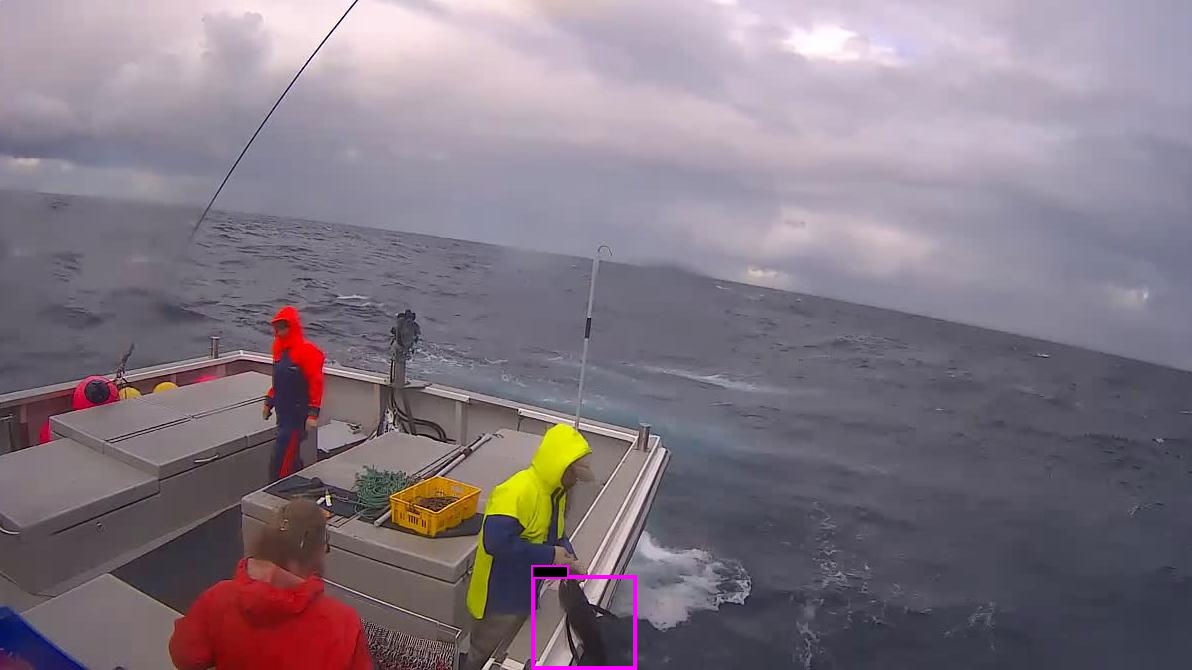

In [0]:
Image.open('predictions.jpg')

In [0]:
! ./darknet/darknet detector test cfg_fish/obj.data cfg_fish/fish_yolov3.cfg weights/fish_yolov3_2000.weights test_stg1/img_05953.jpg

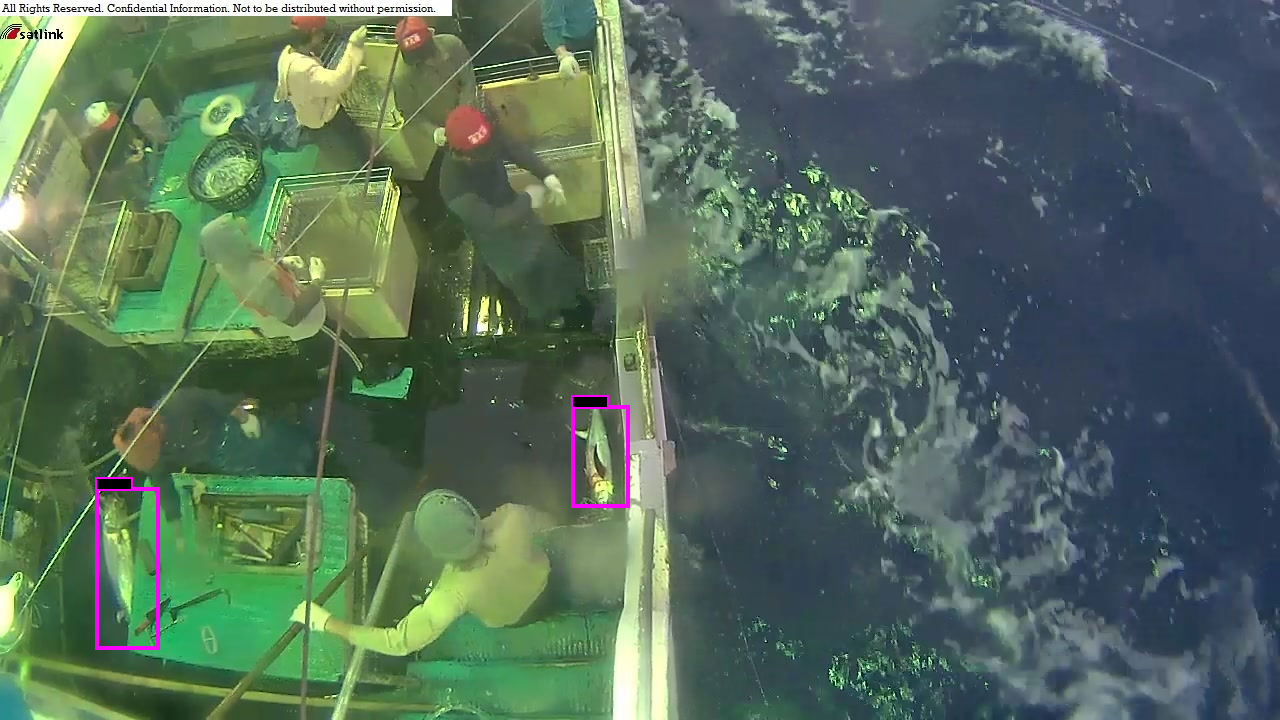

In [0]:
Image.open('predictions.jpg')

draw in python

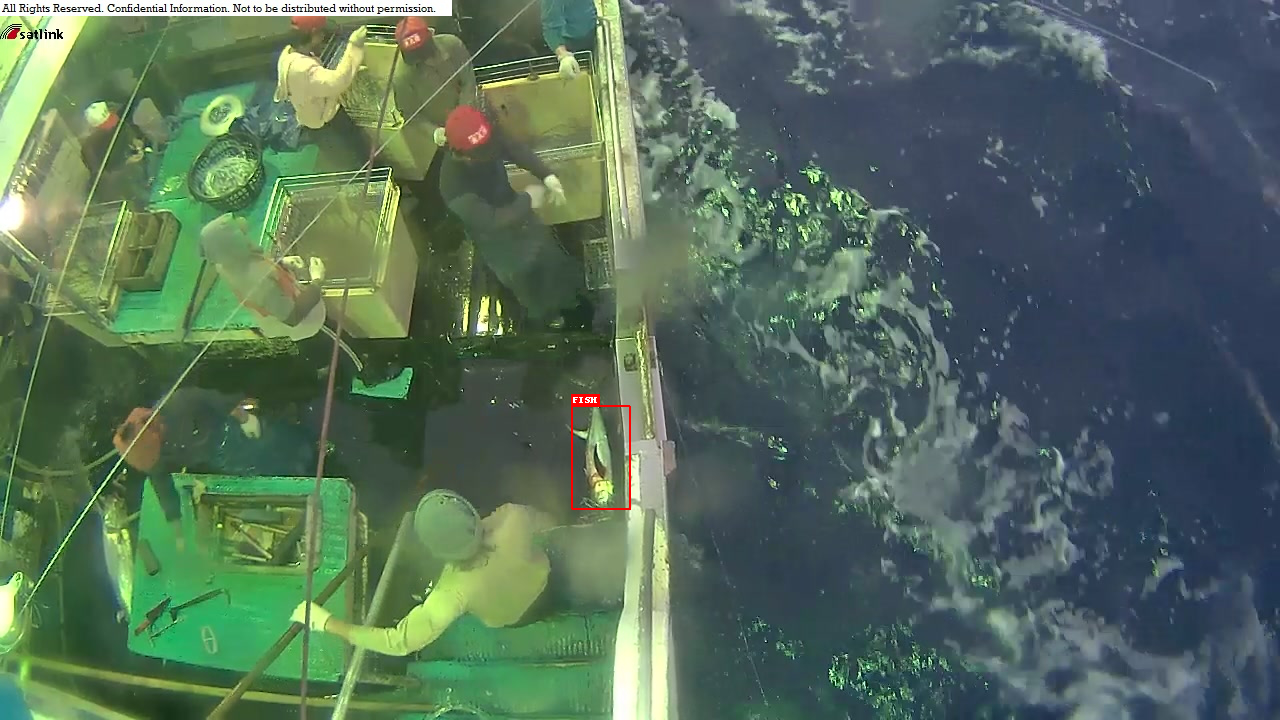

In [0]:
im = Image.open('test_stg1/img_05953.jpg')
box_location = [571,405,571+58,405+103]
draw = ImageDraw.Draw(im)
font = ImageFont.load_default()
draw.rectangle(box_location, outline='red')
draw.rectangle([l+1 for l in box_location], outline='red')
text_size = font.getsize('FISH')
text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                    box_location[1]]
draw.rectangle(xy=textbox_location, fill='red')
draw.text(xy=text_location, text='FISH', fill='white',
          font=font)

im

In [0]:
%%time
! ./darknet/darknet detector test cfg_fish/obj.data cfg_fish/fish_yolov3.cfg weights/fish_yolov3_2700.weights -ext_output < cfg_fish/test.txt > result.txt

In [0]:
!cp result.txt /content/drive/My\ Drive/DL_projects/cv_fish/

### Save crops

In [55]:
with open(os.path.join(path, 'cfg_fish', 'test.txt')) as f:
    test_files = f.readlines()

print(len(test_files))
test_files[:5]

13153


['test_stg1/img_01537.jpg\n',
 'test_stg1/img_05119.jpg\n',
 'test_stg1/img_01681.jpg\n',
 'test_stg1/img_03231.jpg\n',
 'test_stg1/img_03967.jpg\n']

In [54]:
test_files[-5:]

['test_stg2/image_08433.jpg\n',
 'test_stg2/image_06523.jpg\n',
 'test_stg2/image_03775.jpg\n',
 'test_stg2/image_07389.jpg\n',
 'test_stg2/image_05206.jpg\n']

In [0]:
#!cp /content/drive/My\ Drive/DL_projects/cv_fish/result.txt ./
with open('result.txt') as f:
    results = f.readlines()

results = results[2:-1]

In [66]:
len(results)

22474

In [67]:
results[:10]

['Enter Image Path: test_stg1/img_01537.jpg: Predicted in 41.290000 milli-seconds.\n',
 'fish: 81%\t(left_x:  636   top_y:  331   width:  133   height:  182)\n',
 'Enter Image Path: test_stg1/img_05119.jpg: Predicted in 41.205000 milli-seconds.\n',
 'fish: 90%\t(left_x:  716   top_y:  516   width:  181   height:  217)\n',
 'Enter Image Path: test_stg1/img_01681.jpg: Predicted in 41.307000 milli-seconds.\n',
 'fish: 70%\t(left_x:  149   top_y:  365   width:  233   height:   95)\n',
 'Enter Image Path: test_stg1/img_03231.jpg: Predicted in 41.227000 milli-seconds.\n',
 'fish: 60%\t(left_x:  799   top_y:  306   width:   95   height:   88)\n',
 'Enter Image Path: test_stg1/img_03967.jpg: Predicted in 41.345000 milli-seconds.\n',
 'fish: 91%\t(left_x:  771   top_y:   65   width:  260   height:  166)\n']

In [68]:
results[-10:]

['Enter Image Path: test_stg2/image_08433.jpg: Predicted in 40.979000 milli-seconds.\n',
 'fish: 63%\t(left_x:  496   top_y:  569   width:  162   height:   47)\n',
 'Enter Image Path: test_stg2/image_06523.jpg: Predicted in 41.341000 milli-seconds.\n',
 'fish: 34%\t(left_x:  580   top_y:  525   width:   83   height:   69)\n',
 'Enter Image Path: test_stg2/image_03775.jpg: Predicted in 41.330000 milli-seconds.\n',
 'fish: 31%\t(left_x:  486   top_y:  509   width:  120   height:   38)\n',
 'Enter Image Path: test_stg2/image_07389.jpg: Predicted in 41.226000 milli-seconds.\n',
 'fish: 75%\t(left_x:  428   top_y:  566   width:   88   height:   96)\n',
 'Enter Image Path: test_stg2/image_05206.jpg: Predicted in 41.334000 milli-seconds.\n',
 'fish: 45%\t(left_x:  492   top_y:  478   width:  178   height:  111)\n']

In [69]:
%%time
line_id, file_id = 0, 0

while True:
    if line_id+1 == len(results):
        if results[line_id].startswith('Enter'):
            fname = test_files[file_id][:-1]
            copyfile(os.path.join(path, fname), os.path.join(path, 'test_cls', fname.split('/')[-1]))
        else:
            detects.append( [int(s) for s in re.findall(r'\d+', results[line_id])] )
            detects = sorted(detects)
            fname = test_files[file_id][:-1]
            im = Image.open(os.path.join(path, fname))
            bbox = detects[-1][1:]
            bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            im = im.crop(bbox)
            im.save(os.path.join(path, 'test_cls', fname.split('/')[-1]))
        break
    
    if results[line_id].startswith('Enter'):
        if results[line_id+1].startswith('Enter'):
            fname = test_files[file_id][:-1]
            copyfile(os.path.join(path, fname), os.path.join(path, 'test_cls', fname.split('/')[-1]))
            file_id += 1
        else:
            detects = []
    
    else:
        detects.append( [int(s) for s in re.findall(r'\d+', results[line_id])] )
        if results[line_id+1].startswith('Enter'):
            detects = sorted(detects)
            fname = test_files[file_id][:-1]
            im = Image.open(os.path.join(path, fname))
            bbox = detects[-1][1:]
            bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            im = im.crop(bbox)
            im.save(os.path.join(path, 'test_cls', fname.split('/')[-1]))
            file_id += 1
    
    line_id += 1

CPU times: user 1min 31s, sys: 2.6 s, total: 1min 34s
Wall time: 1min 34s


In [70]:
len(os.listdir('test_cls'))

13153